# Project: Let's open our second gym, wait but *where*!!!

## 1. Introduction  
The owners of a gym are looking to open their second location. Their current gym is located in the borough Feijenoord, Rotterdam, The Netherlands. 
Business is going well. Their concept is mainly focussed on the youth and through initiatives with local restaurants, bars, and sport clubs the gym is advertised. This is thought to be a major part of the success, and makes the location of the gym crucial. 
The second location is to be opened in Amsterdam, the Netherlands. The owners are not familiar with this area, because of the long lasting rivalry between the two cities they are yet to visit the place! Not wanting to spend more time in Amsterdam then absolutely necessarily, they decide to rely on data to find the boroughs most similar to Feijenoord. 

### 1.1 The business problem 
The concept of the current gym is heavily depended on the location. To ensure success of the second location in Amsterdam, the area should be similar to the current location. However, it is unknown which boroughs in Amsterdam are similar to Feijenoord. Therefore, the goal of the project is to find the answer to the following research question: "Which of the boroughs in Amsterdam are similar to Feijenoord, Rotterdam based on the target group of the gym (youths) and the presence of local enterprises (e.g. restaurants, bars and sport clubs)? 

### 1.2. The Analytical Approach 
To answer the research question the neigborhoods should be grouped. A clustering approach is best suited as the data is unlabeled. The boroughs in the same group as Feijenoord are similar to the current area of the gym. An example of a clustering algorith which can be used is k-means. 

## 2. Data-requirements and available data-sources
First the different boroughs in Amsterdam should be mapped. In order for data to be relevant it must be possible to group the data according to these boroughs. Furthermore, the data should be recently updated.  
For a relevant comparision it is crucial to only include relevant data. This is based on the research question and include:
- Population composition based on age and income 
- Number of local restaurants, bars and sport clubs relative to the total population

This means the data is two-fold. The first part consist out of local population composition data. The second part is purely location data. 

**Population composition**  
In The Netherlands the Central Bureau of Statistics (CBS) is the national statiscal office which provided reliable statiscal information and data. (Much of) the data is open source and can be downloaded in csv format from their data portal. This is includes a dataset [Key figures of buroughs and neighborhoods](https://opendata.cbs.nl/statline/#/CBS/nl/dataset/84799NED/table?ts=1612255554791) which provides key figures such as population compositions per neighborhood and borough overall for all major cities in The Netherlands. Metadata of the dataset  can be found in this [csv file](https://opendata.cbs.nl/statline/portal.html?_la=nl&_catalog=CBS&tableId=84799NED&_theme=235#). Besides providing descriptions of the different columns in the dataset, the metadata also links the "Codering_3" column  to the names of the boroughs. The picture below shows a snapshot of a part of the dataset and of the metadata: 
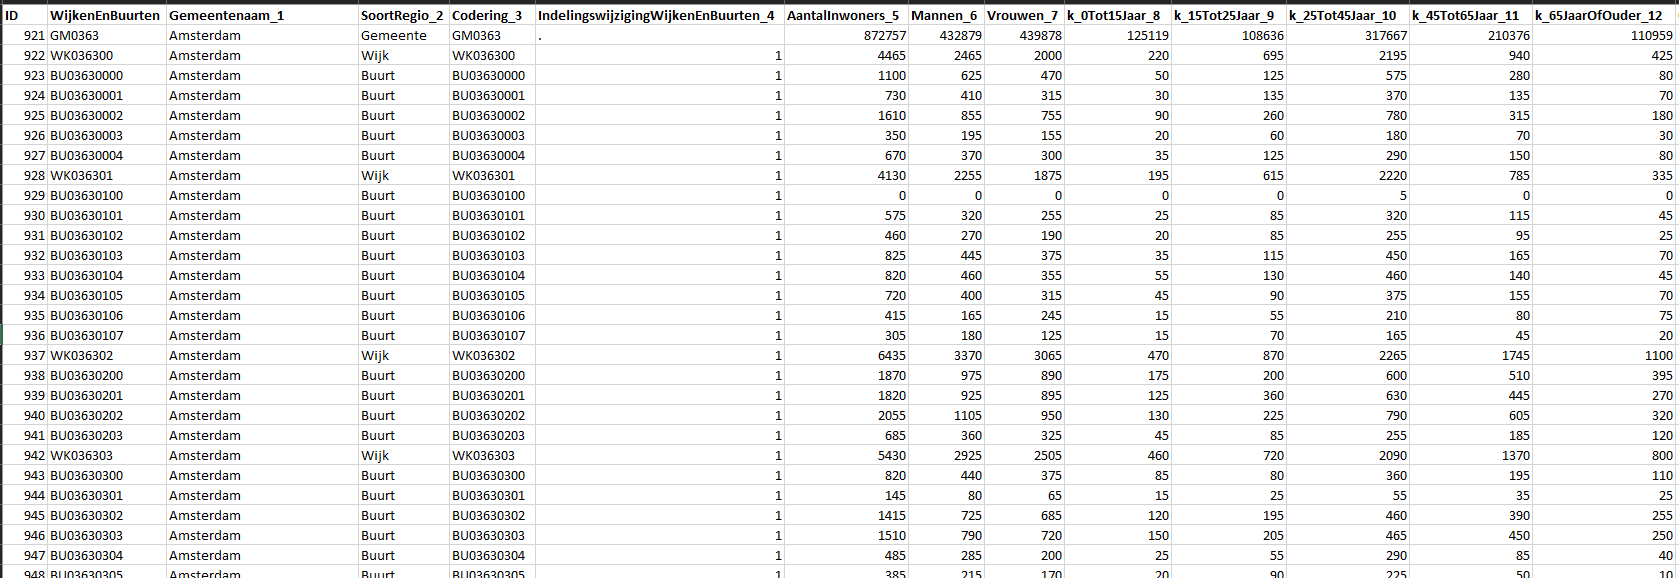
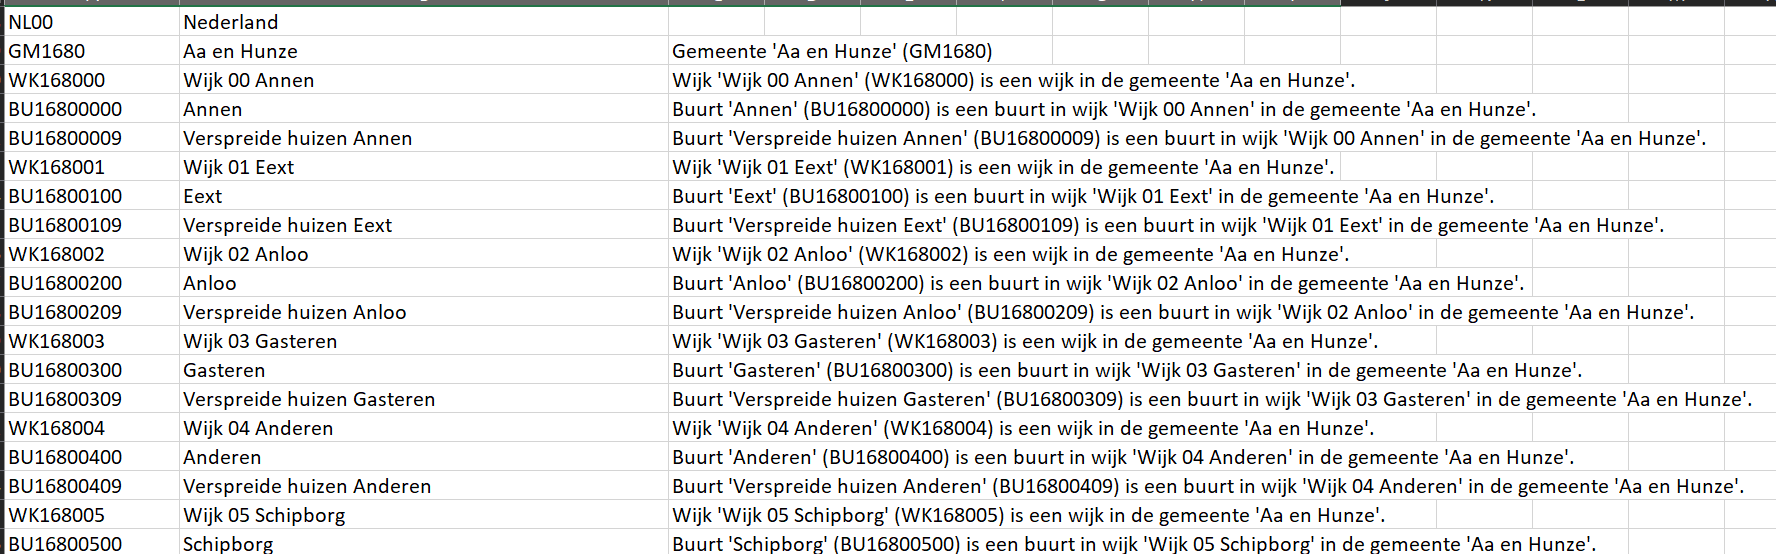

As the dataset includes about 100 columns, the table below only describes the relavant columns based on the research question. Almost all data will be from 2020. The only exception is the average income, the most recent dataset for which this column is complete is 2017.  
In 5 columns the population per age interval is given, together with the column total population this can be used to create a age distribution for the different boroughs. 
GemiddeldInkomenPerInwoner_66 gives the average income per borough. This data in not available yet for 2020. The most recent data is in the data set for 2017 and will  be used instead.

| Column names  |  Descriptions |
|---|---|
|Gemeentenaam_1   |Gives the name of the corresponding city of the neighborhood or borough|
| WijkenEnBuurten  | Gives the code of the neighborhoods and boroughs, the metadata file can be used to retrieve the name using this key |
| SoortRegio_2 | Gives the type of area: Gemeente: township, Wijk: borough, Buurt: neighborhood|
| AantalInwoners_5  | Gives the total population of the neighborhoods or borough  |
| k_0Tot15Jaar_8 ... k_65JaarOfOuder | Population between intervals of age: 0 - 15 years, 15 to 25 years, 25 to 45 years, 45 to 65 years, 65 or older|
| GemiddeldInkomenPerInwoner_66 | Average income per Person in thousands, not available for 2020, 2017 used instead |


**Location data**   
Information about the type and number of local enterprises, such as restaurants, bars, and sport clubs will be aquired using the location data of Foursquare. In order to retrieve information from Foursquare the coordinates of the boroughs are needed. These coordinates will be retrieved using the package geopy, example given below. The name of the neighborhoods will be retrieved from the "Key figures of buroughs and neighborhoods" metadata file. The number of enterprises per type will be retrieved from Foursquare and normalized to the total population in that area. This can then be used to compare the neighborhoods together with the population compositions.  

In [6]:
import geopy

In [177]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="Coursera_course")
location = geolocator.geocode("Amsterdam")
str(type(location.latitude))
#print(location.address)
#print((location.latitude, location.longitude))

"<class 'float'>"

## 2. Methodology 
Importing the needed libraries and reading the csv files into a pandas dataframe

### 2.1 Reading in the CBS data set from the csv file

In [18]:
import numpy as np
import pandas as pd

The data rows consists out of cities, boroughs, and neighborhoods. As we are only interested in the boroughs (=Wijk) we filer on this type

In [19]:
# Read the 2020 csv file into a pandas dataframe
CBS_data_raw_2020 = pd.read_csv("RotterdamAmsterdam2020.csv", header = 0, delimiter = ";" )

# Extract relevant columns: 
CBS_data_raw_2020 = CBS_data_raw_2020[["WijkenEnBuurten", 
                                       "Gemeentenaam_1",
                                       "SoortRegio_2",
                                       "AantalInwoners_5",
                                       "k_0Tot15Jaar_8",
                                       "k_15Tot25Jaar_9", 
                                       "k_25Tot45Jaar_10", 
                                       "k_45Tot65Jaar_11", 
                                       "k_65JaarOfOuder_12"]]

# Read the 2017 csv file into a pandas dataframe and extract relevant columns:
CBS_data_raw_2017 = pd.read_csv("RotterdamAmsterdam2017.csv", header = 0, delimiter = ";" )
CBS_data_raw_2017 = CBS_data_raw_2017[["WijkenEnBuurten", 
                                       "Gemeentenaam_1", 
                                       "GemiddeldInkomenPerInwoner_66"]]

# Merge the two data frames on the "WijkenEnBuurten" key 
CBS_data = CBS_data_raw_2020.merge(right = CBS_data_raw_2017[["WijkenEnBuurten", "GemiddeldInkomenPerInwoner_66"]], how = 'left', on = 'WijkenEnBuurten')

# Change column names 
CBS_data.rename(columns = {"WijkenEnBuurten": "Key", 
                           "Gemeentenaam_1": "City", 
                           "SoortRegio_2": "Area_type",
                           "AantalInwoners_5": "Total Population",
                           "k_0Tot15Jaar_8": "0_to_15_years", 
                           "k_15Tot25Jaar_9": "15_to_25_years", 
                           "k_25Tot45Jaar_10":"25_to_45_years", 
                           "k_45Tot65Jaar_11": "45_to_65_years", 
                           "k_65JaarOfOuder_12":"65_years_or_older", 
                           "GemiddeldInkomenPerInwoner_66": "Average_income_2017"}, inplace = True)

CBS_data["Key"] = CBS_data["Key"].str.strip()
CBS_data["City"] = CBS_data["City"].str.strip()
CBS_data["Area_type"] = CBS_data["Area_type"].str.strip()
CBS_data.head() 

,Key,City,Area_type,Total Population,0_to_15_years,15_to_25_years,25_to_45_years,45_to_65_years,65_years_or_older,Average_income_2017
0,GM0363,Amsterdam,Gemeente,872757,125119,108636,317667,210376,110959,28.9
1,WK036300,Amsterdam,Wijk,4465,220,695,2195,940,425,31.5
2,BU03630000,Amsterdam,Buurt,1100,50,125,575,280,80,34.3
3,BU03630001,Amsterdam,Buurt,730,30,135,370,135,70,29.1
4,BU03630002,Amsterdam,Buurt,1610,90,260,780,315,180,27.8


Only interested in the boroughs (Area_type = "wijk"), so the rows are filtered on this condition and the "Area_type" column is dropped:

In [20]:
CBS_data = CBS_data[CBS_data["Area_type"] == "Wijk"].drop("Area_type", axis = 1)

CBS_data.head()

,Key,City,Total Population,0_to_15_years,15_to_25_years,25_to_45_years,45_to_65_years,65_years_or_older,Average_income_2017
1,WK036300,Amsterdam,4465,220,695,2195,940,425,31.5
7,WK036301,Amsterdam,4130,195,615,2220,785,335,34.5
16,WK036302,Amsterdam,6435,470,870,2265,1745,1100,62.1
21,WK036303,Amsterdam,5430,460,720,2090,1370,800,57.4
29,WK036304,Amsterdam,9705,760,1100,3315,2760,1785,36.2


The population per age interval is given in absolute numbers, making comparisons down the road difficult. Therefore, these are normalized with the total population in the the neighborhood:

In [21]:
# Dropping the rows where total population is zero: 
indeces = CBS_data[CBS_data["Total Population"] == 0].index
CBS_data.drop(indeces, inplace = True)

#Calculating the distribution of the age 
CBS_data["0_to_15_years"] = CBS_data["0_to_15_years"]/CBS_data["Total Population"]
CBS_data["15_to_25_years"] = CBS_data["15_to_25_years"]/CBS_data["Total Population"]
CBS_data["25_to_45_years"] = CBS_data["25_to_45_years"]/CBS_data["Total Population"]
CBS_data["45_to_65_years"] = CBS_data["45_to_65_years"]/CBS_data["Total Population"]
CBS_data["65_years_or_older"] = CBS_data["65_years_or_older"]/CBS_data["Total Population"]

CBS_data.head(5)

,Key,City,Total Population,0_to_15_years,15_to_25_years,25_to_45_years,45_to_65_years,65_years_or_older,Average_income_2017
1,WK036300,Amsterdam,4465,0.049272,0.155655,0.491601,0.210526,0.095185,31.5
7,WK036301,Amsterdam,4130,0.047215,0.148910,0.537530,0.190073,0.081114,34.5
16,WK036302,Amsterdam,6435,0.073038,0.135198,0.351981,0.271173,0.170940,62.1
21,WK036303,Amsterdam,5430,0.084715,0.132597,0.384899,0.252302,0.147330,57.4
29,WK036304,Amsterdam,9705,0.078310,0.113344,0.341577,0.284389,0.183926,36.2


To get the corresponding names of the neighborhoods we need to use the metadata csv_file: 

In [22]:
# Read in the metadata file: 
metaData = pd.read_csv("83765NED_metadata.csv", delimiter = ";", header = 153).drop("Description", axis = 1)
metaData.rename(columns = {"Title": "Name"}, inplace = True)
metaData["Name"] = metaData["Name"].str.strip()
metaData["Key"] = metaData["Key"].str.strip()
metaData.head()

,Key,Name
0,NL00,Nederland
1,GM1680,Aa en Hunze
2,WK168000,Wijk 00 Annen
3,BU16800000,Annen
4,BU16800009,Verspreide huizen Annen


Merging the metadata with the CBS_data dataframe (adding the names): 

In [23]:
CBS_data = CBS_data.merge(right = metaData, on = "Key", how = "left")

In [24]:
CBS_data.head(15)

,Key,City,Total Population,0_to_15_years,15_to_25_years,25_to_45_years,45_to_65_years,65_years_or_older,Average_income_2017,Name
0,WK036300,Amsterdam,4465,0.049272,0.155655,0.491601,0.210526,0.095185,31.5,Burgwallen-Oude Zijde
1,WK036301,Amsterdam,4130,0.047215,0.148910,0.537530,0.190073,0.081114,34.5,Burgwallen-Nieuwe Zijde
2,WK036302,Amsterdam,6435,0.073038,0.135198,0.351981,0.271173,0.170940,62.1,Grachtengordel-West
3,WK036303,Amsterdam,5430,0.084715,0.132597,0.384899,0.252302,0.147330,57.4,Grachtengordel-Zuid
4,WK036304,Amsterdam,9705,0.078310,0.113344,0.341577,0.284389,0.183926,36.2,Nieuwmarkt/Lastage
5,WK036305,Amsterdam,9275,0.100809,0.087871,0.337466,0.299730,0.175202,36.4,Haarlemmerbuurt
6,WK036306,Amsterdam,19400,0.078093,0.097423,0.378093,0.278351,0.168814,34.9,Jordaan
7,WK036307,Amsterdam,7295,0.094585,0.119945,0.416038,0.240576,0.131597,42.7,De Weteringschans
8,WK036308,Amsterdam,7480,0.084893,0.133021,0.366979,0.259358,0.157086,39.9,Weesperbuurt/Plantage
9,WK036309,Amsterdam,13685,0.106321,0.119474,0.332115,0.288637,0.154914,30.3,Oostelijke Eilanden/Kadijken


Checking how many neighborhoods we have per city: 

In [25]:
CBS_data.groupby("City").count()

,Key,Total Population,0_to_15_years,15_to_25_years,25_to_45_years,45_to_65_years,65_years_or_older,Average_income_2017,Name
City,,,,,,,,,
Amsterdam,98,98,98,98,98,98,98,98,98
Rotterdam,17,17,17,17,17,17,17,17,17


There are 98 neighborhoods for amsterdam which seems about right. However, there are still 17 neighborhoods for Rotterdam while only Feijenoord is relevant: 

In [26]:
#Isolate Feijenoord: 
Feijenoord = CBS_data[CBS_data["Name"] == "Feijenoord"]
Feijenoord

#Only keep rows with City = "Amsterdam" from CBS_data: 
CBS_data = CBS_data[CBS_data["City"] == "Amsterdam"]

# Append Feijenoord: 
CBS_data = CBS_data.append(Feijenoord)

In [27]:
CBS_data.tail(2)

,Key,City,Total Population,0_to_15_years,15_to_25_years,25_to_45_years,45_to_65_years,65_years_or_older,Average_income_2017,Name
97,WK036398,Amsterdam,1620,0.185185,0.117284,0.216049,0.305556,0.175926,26.2,Driemond
104,WK059910,Rotterdam,76590,0.173782,0.136571,0.308787,0.251012,0.129847,19.2,Feijenoord


Converting the name into address format: 

In [28]:
CBS_data['Address'] = CBS_data["Name"] + ", " +CBS_data["City"]

In [30]:
CBS_data.head()

,Key,City,Total Population,0_to_15_years,15_to_25_years,25_to_45_years,45_to_65_years,65_years_or_older,Average_income_2017,Name,Address
0,WK036300,Amsterdam,4465,0.049272,0.155655,0.491601,0.210526,0.095185,31.5,Burgwallen-Oude Zijde,"Burgwallen-Oude Zijde, Amsterdam"
1,WK036301,Amsterdam,4130,0.047215,0.148910,0.537530,0.190073,0.081114,34.5,Burgwallen-Nieuwe Zijde,"Burgwallen-Nieuwe Zijde, Amsterdam"
2,WK036302,Amsterdam,6435,0.073038,0.135198,0.351981,0.271173,0.170940,62.1,Grachtengordel-West,"Grachtengordel-West, Amsterdam"
3,WK036303,Amsterdam,5430,0.084715,0.132597,0.384899,0.252302,0.147330,57.4,Grachtengordel-Zuid,"Grachtengordel-Zuid, Amsterdam"
4,WK036304,Amsterdam,9705,0.078310,0.113344,0.341577,0.284389,0.183926,36.2,Nieuwmarkt/Lastage,"Nieuwmarkt/Lastage, Amsterdam"


### 2.2. Getting the Latitudes and Longitudes of the neighborhoods

Before getting the location data for the different neighborhoods, we need to have the latitudes and longtitudes for the neighborhoods using the Geopy package: 

In [31]:
# Import needed functions: 
from geopy.geocoders import Nominatim

In [32]:
# Getting longitude and latitude values based on the addresses: 
CBS_data["Latitude"] = 0.0
CBS_data["Longitude"] = 0.0
geolocator = Nominatim(user_agent="Coursera_course")

for index, row in CBS_data.iterrows(): 
    location = geolocator.geocode(row["Address"])
    
    if hasattr(location, "latitude"):
        CBS_data.at[index, "Latitude"] = location.latitude
        CBS_data.at[index, "Longitude"] = location.longitude
        print(row["Address"], row["Latitude"])
    else: 
        row["Latitude"] = None
        row["longitude"] = None
        print('Address not found')

Burgwallen-Oude Zijde, Amsterdam 0.0
Burgwallen-Nieuwe Zijde, Amsterdam 0.0
Grachtengordel-West, Amsterdam 0.0
Address not found
Nieuwmarkt/Lastage, Amsterdam 0.0
Haarlemmerbuurt, Amsterdam 0.0
Jordaan, Amsterdam 0.0
De Weteringschans, Amsterdam 0.0
Weesperbuurt/Plantage, Amsterdam 0.0
Address not found
Address not found
Address not found
Houthavens, Amsterdam 0.0
Address not found
Staatsliedenbuurt, Amsterdam 0.0
Centrale Markt, Amsterdam 0.0
Frederik Hendrikbuurt, Amsterdam 0.0
Da Costabuurt, Amsterdam 0.0
Kinkerbuurt, Amsterdam 0.0
Van Lennepbuurt, Amsterdam 0.0
Helmersbuurt, Amsterdam 0.0
Overtoomse Sluis, Amsterdam 0.0
Vondelbuurt, Amsterdam 0.0
Zuidas, Amsterdam 0.0
Oude Pijp, Amsterdam 0.0
Nieuwe Pijp, Amsterdam 0.0
Zuid Pijp, Amsterdam 0.0
Weesperzijde, Amsterdam 0.0
Oosterparkbuurt, Amsterdam 0.0
Dapperbuurt, Amsterdam 0.0
Transvaalbuurt, Amsterdam 0.0
Indische Buurt West, Amsterdam 0.0
Indische Buurt Oost, Amsterdam 0.0
Oostelijk Havengebied, Amsterdam 0.0
Address not found
I

In [33]:
CBS_data.tail(10)

,Key,City,Total Population,0_to_15_years,15_to_25_years,25_to_45_years,45_to_65_years,65_years_or_older,Average_income_2017,Name,Address,Latitude,Longitude
89,WK036390,Amsterdam,13615,0.127433,0.104664,0.331987,0.206390,0.230261,36.0,Buitenveldert-West,"Buitenveldert-West, Amsterdam",52.328647,4.873523
90,WK036391,Amsterdam,8100,0.117901,0.091358,0.326543,0.195679,0.269136,33.4,Buitenveldert-Oost,"Buitenveldert-Oost, Amsterdam",0.000000,0.000000
91,WK036392,Amsterdam,740,0.020270,0.500000,0.385135,0.087838,0.020270,19.5,Amstel III/Bullewijk,"Amstel III/Bullewijk, Amsterdam",52.301099,4.951654
92,WK036393,Amsterdam,24935,0.152998,0.198115,0.325446,0.244235,0.079406,17.6,"Bijlmer Centrum (D,F,H)","Bijlmer Centrum (D,F,H), Amsterdam",0.000000,0.000000
93,WK036394,Amsterdam,29770,0.168122,0.148640,0.294256,0.264024,0.125126,20.0,"Bijlmer Oost (E,G,K)","Bijlmer Oost (E,G,K), Amsterdam",0.000000,0.000000
94,WK036395,Amsterdam,3035,0.123558,0.085667,0.322900,0.261944,0.207578,28.3,Nellestein,"Nellestein, Amsterdam",52.308899,4.981825
95,WK036396,Amsterdam,18385,0.173511,0.128637,0.264346,0.266794,0.167256,19.5,Holendrecht/Reigersbos,"Holendrecht/Reigersbos, Amsterdam",0.000000,0.000000
96,WK036397,Amsterdam,11325,0.152318,0.122737,0.269316,0.303753,0.152318,22.7,Gein,"Gein, Amsterdam",52.297238,4.988091
97,WK036398,Amsterdam,1620,0.185185,0.117284,0.216049,0.305556,0.175926,26.2,Driemond,"Driemond, Amsterdam",52.305405,5.016549
104,WK059910,Rotterdam,76590,0.173782,0.136571,0.308787,0.251012,0.129847,19.2,Feijenoord,"Feijenoord, Rotterdam",51.909661,4.506957


Not all addresses are found, for these address a 0.00 was returned. This was the case for 25 neighborhoods: 

In [34]:
print(CBS_data[["Key","Latitude"]][CBS_data["Latitude"]== 0.0].count())
CBS_data[["Key","Address"]][CBS_data["Latitude"]== 0.0].head(10)

Key         25
Latitude    25
dtype: int64


,Key,Address
3,WK036303,"Grachtengordel-Zuid, Amsterdam"
9,WK036309,"Oostelijke Eilanden/Kadijken, Amsterdam"
10,WK036310,"Westelijk Havengebied, Amsterdam"
11,WK036311,"Bedrijventerrein Sloterdijk, Amsterdam"
13,WK036313,"Spaarndammer- en Zeeheldenbuurt, Amsterdam"
34,WK036334,"Zeeburgereiland/Nieuwe Diep, Amsterdam"
40,WK036340,"Geuzenbuurt, Amsterdam"
44,WK036344,"Hoofddorppleinbuurt, Amsterdam"
57,WK036358,"Omval/Overamstel, Amsterdam"
58,WK036359,"Prinses Irenebuurt e.o., Amsterdam"


Unfortunely, no other database was found to get the coordinates for these neighborhoods, so they are dropped. 

In [35]:
indeces = CBS_data[CBS_data["Latitude"]==0].index
CBS_data.drop(indeces, inplace =True)
CBS_data.groupby("City").count()

,Key,Total Population,0_to_15_years,15_to_25_years,25_to_45_years,45_to_65_years,65_years_or_older,Average_income_2017,Name,Address,Latitude,Longitude
City,,,,,,,,,,,,
Amsterdam,73,73,73,73,73,73,73,73,73,73,73,73
Rotterdam,1,1,1,1,1,1,1,1,1,1,1,1


In [36]:
CBS_data.tail(5)

,Key,City,Total Population,0_to_15_years,15_to_25_years,25_to_45_years,45_to_65_years,65_years_or_older,Average_income_2017,Name,Address,Latitude,Longitude
91,WK036392,Amsterdam,740,0.020270,0.500000,0.385135,0.087838,0.020270,19.5,Amstel III/Bullewijk,"Amstel III/Bullewijk, Amsterdam",52.301099,4.951654
94,WK036395,Amsterdam,3035,0.123558,0.085667,0.322900,0.261944,0.207578,28.3,Nellestein,"Nellestein, Amsterdam",52.308899,4.981825
96,WK036397,Amsterdam,11325,0.152318,0.122737,0.269316,0.303753,0.152318,22.7,Gein,"Gein, Amsterdam",52.297238,4.988091
97,WK036398,Amsterdam,1620,0.185185,0.117284,0.216049,0.305556,0.175926,26.2,Driemond,"Driemond, Amsterdam",52.305405,5.016549
104,WK059910,Rotterdam,76590,0.173782,0.136571,0.308787,0.251012,0.129847,19.2,Feijenoord,"Feijenoord, Rotterdam",51.909661,4.506957


Visualizing the coordinates on the map:

In [37]:
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [38]:
# create map of Toronto using latitude and longitude values
latitude = 52.301099
longitude = 4.981825
map_amsterdam = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, name, total_population in zip(CBS_data['Latitude'], CBS_data['Longitude'], CBS_data['Name'], CBS_data['Total Population']):
    label = '{}, population: {}'.format(name, total_population)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_amsterdam)  
    
map_amsterdam

### 2.3 Getting the Location data from Foursquare

In [39]:
# Importing the libraries: 
import requests

In [40]:
#Foursqaure credentials
CLIENT_ID = '3P1TUXWEL0M0QHRJZXJK2E224H31PMMMUV3A0XPLJIX24HY0' # your Foursquare ID
CLIENT_SECRET = 'MPSRTTAZXMJ0VITA2RODBQ0CEEMMR3JF00AJIUL2DLXGMKVA' # your Foursquare Secret
ACCESS_TOKEN = '4AIP05UQF5YA3RS53HPCFB500JAPJNEMAMGPU4INBIYNES2E' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 30

In [41]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [42]:
def getNearbyVenues(names, latitudes, longitudes, radius= 1000):
    # Funtion to retrieve nearby venues
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [43]:
#Getting the nearby venues for each neighborhood: 
Venues = getNearbyVenues(names=CBS_data['Name'],
                                   latitudes=CBS_data['Latitude'],
                                   longitudes=CBS_data['Longitude']
                                  )

Burgwallen-Oude Zijde
Burgwallen-Nieuwe Zijde
Grachtengordel-West
Nieuwmarkt/Lastage
Haarlemmerbuurt
Jordaan
De Weteringschans
Weesperbuurt/Plantage
Houthavens
Staatsliedenbuurt
Centrale Markt
Frederik Hendrikbuurt
Da Costabuurt
Kinkerbuurt
Van Lennepbuurt
Helmersbuurt
Overtoomse Sluis
Vondelbuurt
Zuidas
Oude Pijp
Nieuwe Pijp
Zuid Pijp
Weesperzijde
Oosterparkbuurt
Dapperbuurt
Transvaalbuurt
Indische Buurt West
Indische Buurt Oost
Oostelijk Havengebied
IJburg West
Sloterdijk
Landlust
Erasmuspark
De Kolenkit
Van Galenbuurt
Hoofdweg e.o.
Westindische Buurt
Schinkelbuurt
Willemspark
Museumkwartier
Stadionbuurt
Apollobuurt
IJburg Zuid
Scheldebuurt
IJselbuurt
Rijnbuurt
Frankendael
Middenmeer
Betondorp
Volewijck
IJplein/Vogelbuurt
Tuindorp Nieuwendam
Tuindorp Buiksloot
Tuindorp Oostzaan
Oostzanerwerf
Kadoelen
Waterlandpleinbuurt
Buikslotermeer
Banne Buiksloot
Waterland
Elzenhagen
Geuzenveld
Eendracht
Osdorp-Oost
De Punt
Slotervaart Noord
Overtoomse Veld
Westlandgracht
Buitenveldert-West
Amste

In [44]:
Venues.tail(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
2068,Feijenoord,51.909661,4.506957,Basic-Fit,51.910036,4.501052,Gym / Fitness Center
2069,Feijenoord,51.909661,4.506957,Anytime Fitness,51.906806,4.495833,Gym / Fitness Center
2070,Feijenoord,51.909661,4.506957,Sultan Ahmet Restaurant,51.904385,4.502389,Turkish Restaurant
2071,Feijenoord,51.909661,4.506957,Station Rotterdam Zuid,51.904847,4.509812,Train Station
2072,Feijenoord,51.909661,4.506957,De Schuimspaan,51.904311,4.502773,Bar
2073,Feijenoord,51.909661,4.506957,Bab Al-Hara,51.903954,4.497478,Middle Eastern Restaurant
2074,Feijenoord,51.909661,4.506957,Kruidvat,51.904945,4.503755,Drugstore
2075,Feijenoord,51.909661,4.506957,HAL4.1,51.911859,4.519602,Concert Hall
2076,Feijenoord,51.909661,4.506957,Verhage,51.904849,4.503532,Snack Place
2077,Feijenoord,51.909661,4.506957,Restaurant Café Okay,51.910395,4.498151,Restaurant


In [45]:
DistinctVenues = Venues["Venue Category"].str.upper().unique()
DistinctVenues.sort()
print(DistinctVenues[0:10])
DistinctVenues.shape

['ACCESSORIES STORE' 'AFGHAN RESTAURANT' 'AFRICAN RESTAURANT' 'ARCADE'
 'ART GALLERY' 'ART MUSEUM' 'ARTS & CRAFTS STORE' 'ARTS & ENTERTAINMENT'
 'ASIAN RESTAURANT' 'ATHLETICS & SPORTS']


(231,)

There are 237 distinct venue categories. We have to find those that are relevant: 

In [46]:
# Getting the categories with the word GYM as compition: 
gymCategories = []
print(type(gymCategories))
for venues in DistinctVenues: 
    if "GYM" in venues: 
        gymCategories.append(venues)
        
    
            
print(gymCategories)
        

<class 'list'>
['CLIMBING GYM', 'GYM', 'GYM / FITNESS CENTER', 'GYM POOL', 'GYMNASTICS GYM']


The categories CLIMBING GYM, GYM POOL, and GYMNASTICS GYM do not seem to be compition for our normal fitness gym, so let's drop those: 

In [47]:
gymCategories = ['GYM', 'GYM / FITNESS CENTER']

# Renaming "GYM / FITNESS CENTER" to "GYM":
Venues.loc[(Venues["Venue Category"].str.upper()=="GYM / FITNESS CENTER"), "Venue Category"] = "GYM"
DistinctVenues = Venues["Venue Category"].str.upper().unique()
DistinctVenues.sort()

We also need to retrieve all venues that are potential partners for initiatives in reaching the costumers. One of the most relevant are all the restaurants. However, the different type of restaurants, such as french vs. argentina restaurants are listed as different categories. As this is not relevant all categories containing the word restaurant should be grouped: 

In [48]:
restaurantCategories = []

for venue in DistinctVenues: 
    if "RESTAURANT" in venue: 
        restaurantCategories.append(venue)

# Renaming the restaurant types to restaurant:
for restaurantTypes in restaurantCategories:
    Venues.loc[(Venues["Venue Category"].str.upper()== restaurantTypes), "Venue Category"] = "RESTAURANT"

DistinctVenues = Venues["Venue Category"].str.upper().unique()
DistinctVenues.sort()

The same will be done for the bars and cafes:

In [49]:
barCategories = []

for venue in DistinctVenues: 
    if ("BAR" in venue): 
        barCategories.append(venue)
    if ("CAFÉ" in venue):
        barCategories.append(venue)
print(barCategories)

['BAR', 'BEER BAR', 'CAFÉ', 'COCKTAIL BAR', 'GAY BAR', 'HOTEL BAR', 'JUICE BAR', 'PET CAFÉ', 'SALON / BARBERSHOP', 'WINE BAR']


Most barbershops do not have a bar, and pets cannot pay for the gym membership, also pubs should be added! 

In [50]:
barCategories = []

for venue in DistinctVenues: 
    if ("BAR" in venue) and ("BARBER" not in venue): 
        barCategories.append(venue)
    if ("CAFÉ" in venue) and ("PET" not in venue):
        barCategories.append(venue)
    if ("PUB" in venue) and ("ART" not in venue):
        barCategories.append(venue)
print(barCategories)

['BAR', 'BEER BAR', 'CAFÉ', 'COCKTAIL BAR', 'GASTROPUB', 'GAY BAR', 'HOTEL BAR', 'JUICE BAR', 'PUB', 'WINE BAR']


In [51]:
# Renaming the bars and cafés to "BAR":
for barTypes in barCategories:
    Venues.loc[(Venues["Venue Category"].str.upper()== barTypes), "Venue Category"] = "BAR"

DistinctVenues = Venues["Venue Category"].str.upper().unique()
DistinctVenues.sort()
print(DistinctVenues)
DistinctVenues.shape

['ACCESSORIES STORE' 'ARCADE' 'ART GALLERY' 'ART MUSEUM'
 'ARTS & CRAFTS STORE' 'ARTS & ENTERTAINMENT' 'ATHLETICS & SPORTS'
 'BAGEL SHOP' 'BAKERY' 'BAR' 'BASEBALL FIELD' 'BASKETBALL STADIUM'
 'BBQ JOINT' 'BEACH' 'BED & BREAKFAST' 'BEER GARDEN' 'BEER STORE'
 'BIKE RENTAL / BIKE SHARE' 'BISTRO' 'BOARD SHOP' 'BOAT OR FERRY'
 'BOOKSTORE' 'BOTANICAL GARDEN' 'BOUTIQUE' 'BRASSERIE' 'BREAKFAST SPOT'
 'BREWERY' 'BURGER JOINT' 'BUS STATION' 'BUS STOP' 'CAFETERIA'
 'CAMERA STORE' 'CAMPGROUND' 'CANAL' 'CASINO' 'CHEESE SHOP'
 'CHOCOLATE SHOP' 'CHURCH' 'CIRCUS' 'CLIMBING GYM' 'CLOTHING STORE'
 'COFFEE SHOP' 'COMEDY CLUB' 'CONCERT HALL' 'CONVENIENCE STORE'
 'COSMETICS SHOP' 'CREPERIE' 'DANCE STUDIO' 'DELI / BODEGA'
 'DEPARTMENT STORE' 'DESIGN STUDIO' 'DESSERT SHOP' 'DINER'
 'DISCOUNT STORE' 'DOG RUN' 'DRUGSTORE' 'ELECTRONICS STORE' 'EVENT SPACE'
 'FARM' 'FARMERS MARKET' 'FISH MARKET' 'FLEA MARKET' 'FLOWER SHOP'
 'FOOD & DRINK SHOP' 'FOOD COURT' 'FOOD SERVICE' 'FOOD STAND' 'FOOD TRUCK'
 'FRIED CHICKEN

(174,)

The number of distinct categories have become managable. Last up are the sport clubs. In this category the used words are varied. So we check the remaining 178 categories visually for relevance: 
- "SPORTS CLUB"
- "TENNIS"
- "YOGA STUDIO"
- "TENNIS COURT"
- "SOCCER FIELD"
- "POOL"
- "POOL HALL"
- "BASEBALL FIELD"


In [52]:
# Renaming sport club related categories: 
sportCategories = ["SPORTS CLUB",
                   "TENNIS",
                   "YOGA STUDIO",
                   "TENNIS COURT",
                   "SOCCER FIELD",
                   "POOL",
                   "POOL HALL",
                   "BASEBALL FIELD"]

for sportTypes in sportCategories:
    Venues.loc[(Venues["Venue Category"].str.upper()== sportTypes), "Venue Category"] = "SPORT CLUB"

DistinctVenues = Venues["Venue Category"].str.upper().unique()
DistinctVenues.sort()
print(DistinctVenues)
DistinctVenues.shape

['ACCESSORIES STORE' 'ARCADE' 'ART GALLERY' 'ART MUSEUM'
 'ARTS & CRAFTS STORE' 'ARTS & ENTERTAINMENT' 'ATHLETICS & SPORTS'
 'BAGEL SHOP' 'BAKERY' 'BAR' 'BASKETBALL STADIUM' 'BBQ JOINT' 'BEACH'
 'BED & BREAKFAST' 'BEER GARDEN' 'BEER STORE' 'BIKE RENTAL / BIKE SHARE'
 'BISTRO' 'BOARD SHOP' 'BOAT OR FERRY' 'BOOKSTORE' 'BOTANICAL GARDEN'
 'BOUTIQUE' 'BRASSERIE' 'BREAKFAST SPOT' 'BREWERY' 'BURGER JOINT'
 'BUS STATION' 'BUS STOP' 'CAFETERIA' 'CAMERA STORE' 'CAMPGROUND' 'CANAL'
 'CASINO' 'CHEESE SHOP' 'CHOCOLATE SHOP' 'CHURCH' 'CIRCUS' 'CLIMBING GYM'
 'CLOTHING STORE' 'COFFEE SHOP' 'COMEDY CLUB' 'CONCERT HALL'
 'CONVENIENCE STORE' 'COSMETICS SHOP' 'CREPERIE' 'DANCE STUDIO'
 'DELI / BODEGA' 'DEPARTMENT STORE' 'DESIGN STUDIO' 'DESSERT SHOP' 'DINER'
 'DISCOUNT STORE' 'DOG RUN' 'DRUGSTORE' 'ELECTRONICS STORE' 'EVENT SPACE'
 'FARM' 'FARMERS MARKET' 'FISH MARKET' 'FLEA MARKET' 'FLOWER SHOP'
 'FOOD & DRINK SHOP' 'FOOD COURT' 'FOOD SERVICE' 'FOOD STAND' 'FOOD TRUCK'
 'FRIED CHICKEN JOINT' 'FRITERIE'

(168,)

All relevant categories have been grouped, now the Venues data is filtered for these categories: 

In [53]:
venuesRelevant = Venues.loc[(Venues['Venue Category']== "RESTAURANT") | (Venues['Venue Category']== "BAR") |(Venues['Venue Category']== "SPORT CLUB")|(Venues['Venue Category']== "GYM") ,]
venuesRelevant.tail(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
2056,Feijenoord,51.909661,4.506957,Restaurant Allure,51.909769,4.499476,RESTAURANT
2061,Feijenoord,51.909661,4.506957,Safir,51.910683,4.499503,RESTAURANT
2062,Feijenoord,51.909661,4.506957,Eethuis De Watertoren,51.912356,4.520230,RESTAURANT
2064,Feijenoord,51.909661,4.506957,Afhaalcentrum De Palmboom,51.905013,4.503818,RESTAURANT
2068,Feijenoord,51.909661,4.506957,Basic-Fit,51.910036,4.501052,GYM
2069,Feijenoord,51.909661,4.506957,Anytime Fitness,51.906806,4.495833,GYM
2070,Feijenoord,51.909661,4.506957,Sultan Ahmet Restaurant,51.904385,4.502389,RESTAURANT
2072,Feijenoord,51.909661,4.506957,De Schuimspaan,51.904311,4.502773,BAR
2073,Feijenoord,51.909661,4.506957,Bab Al-Hara,51.903954,4.497478,RESTAURANT
2077,Feijenoord,51.909661,4.506957,Restaurant Café Okay,51.910395,4.498151,RESTAURANT


Grouping the venues on neighborhood:

In [54]:
venuesRelevantGrouped = venuesRelevant[["Venue Category","Neighborhood", "Venue"]].groupby(["Neighborhood","Venue Category"]).count()
venuesRelevantGrouped

Venue
Neighborhood         Venue Category       
Amstel III/Bullewijk BAR                 2
                     RESTAURANT          6
Apollobuurt          BAR                 2
                     RESTAURANT          4
Banne Buiksloot      GYM                 1
...                                    ...
Zuid Pijp            SPORT CLUB          2
Zuidas               BAR                 2
                     GYM                 1
                     RESTAURANT          5
                     SPORT CLUB          1

[195 rows x 1 columns]

The above table is needed in a one-hot encoding format to merge it with the CBS data. 

In [55]:
venuesCount = pd.get_dummies(venuesRelevant[['Venue Category']], prefix="", prefix_sep="")
venuesCount["Neighborhood"] = venuesRelevant["Neighborhood"]
venuesCount = venuesCount.groupby("Neighborhood").sum().rename(columns = {"BAR": "NumOfBars", 
                                                                          "GYM": "NumOfGyms",
                                                                          "RESTAURANT": "NumOfRestaurants",
                                                                          "SPORT CLUB": "NumOfSportClubs"})
venuesCount.reset_index(inplace = True)
venuesCount.rename(columns = {"Neighborhood": "Name"}, inplace = True)

### 2.4 Merging the location data and the population distrubtion data:

In [96]:
data = CBS_data.merge(right = venuesCount, on = "Name")
data["Average_income_2017"] = pd.to_numeric(data["Average_income_2017"], downcast = 'float')
data

,Key,City,Total Population,0_to_15_years,15_to_25_years,25_to_45_years,45_to_65_years,65_years_or_older,Average_income_2017,Name,Address,Latitude,Longitude,NumOfBars,NumOfGyms,NumOfRestaurants,NumOfSportClubs
0,WK036300,Amsterdam,4465,0.049272,0.155655,0.491601,0.210526,0.095185,31.500000,Burgwallen-Oude Zijde,"Burgwallen-Oude Zijde, Amsterdam",52.371946,4.896103,4,0,2,0
1,WK036301,Amsterdam,4130,0.047215,0.148910,0.537530,0.190073,0.081114,34.500000,Burgwallen-Nieuwe Zijde,"Burgwallen-Nieuwe Zijde, Amsterdam",52.373706,4.889922,7,0,3,0
2,WK036302,Amsterdam,6435,0.073038,0.135198,0.351981,0.271173,0.170940,62.099998,Grachtengordel-West,"Grachtengordel-West, Amsterdam",52.370837,4.885478,3,0,2,0
3,WK036304,Amsterdam,9705,0.078310,0.113344,0.341577,0.284389,0.183926,36.200001,Nieuwmarkt/Lastage,"Nieuwmarkt/Lastage, Amsterdam",52.372177,4.906351,8,0,6,0
4,WK036305,Amsterdam,9275,0.100809,0.087871,0.337466,0.299730,0.175202,36.400002,Haarlemmerbuurt,"Haarlemmerbuurt, Amsterdam",52.382441,4.887193,6,0,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,WK036390,Amsterdam,13615,0.127433,0.104664,0.331987,0.206390,0.230261,36.000000,Buitenveldert-West,"Buitenveldert-West, Amsterdam",52.328647,4.873523,1,0,7,0
68,WK036392,Amsterdam,740,0.020270,0.500000,0.385135,0.087838,0.020270,19.500000,Amstel III/Bullewijk,"Amstel III/Bullewijk, Amsterdam",52.301099,4.951654,2,0,6,0
69,WK036397,Amsterdam,11325,0.152318,0.122737,0.269316,0.303753,0.152318,22.700001,Gein,"Gein, Amsterdam",52.297238,4.988091,0,0,2,0
70,WK036398,Amsterdam,1620,0.185185,0.117284,0.216049,0.305556,0.175926,26.200001,Driemond,"Driemond, Amsterdam",52.305405,5.016549,0,0,0,1


Not every burough is equally big or populated, so the number of venues is normalized to the population in the neighborhood:

In [106]:
dataNormalized = data 

dataNormalized["NumOfBars"] = dataNormalized["NumOfBars"]/dataNormalized["Total Population"]
dataNormalized["NumOfGyms"] = dataNormalized["NumOfGyms"]/dataNormalized["Total Population"]
dataNormalized["NumOfRestaurants"] = dataNormalized["NumOfRestaurants"]/dataNormalized["Total Population"]
dataNormalized["NumOfSportClubs"] = dataNormalized["NumOfSportClubs"]/dataNormalized["Total Population"]

### 2.5 exploratory data analysis  
Before starting to model the data the types, distributions, min and max values of the different variables are investigated.
All the data types are as expected, all the relevant variables for modelling are either floats or integers. 
In all cases the mean, min, max, and std of the variables seem to be logical. There does seem to be large differences between the means and medians of the variable. 
Therefore, normalization of the data set is necessarry. 
Looking at the distributions of the variables, all age intervals seems to normally distributed. 
The other variables have seem to have two or three underlying distribution, which could be helpfull for clusting the data.  
None of the variable combinations seem to have enough corrrelation to make one of data features redundant. The most correlation seems to present between neighbouring age interval, which can be expected. 

Also, visually no groups emerge when plotting two variables against each other. The neighborhood Feijenoord also do not seem to have one distict variable different from the neighborhoods in Amsterdam. 

In [58]:
dataNormalized.dtypes

Key                     object
City                    object
Total Population         int64
0_to_15_years          float64
15_to_25_years         float64
25_to_45_years         float64
45_to_65_years         float64
65_years_or_older      float64
Average_income_2017    float32
Name                    object
Address                 object
Latitude               float64
Longitude              float64
NumOfBars              float64
NumOfGyms              float64
NumOfRestaurants       float64
NumOfSportClubs        float64
dtype: object

In [59]:
dataNormalized.describe()

,Total Population,0_to_15_years,15_to_25_years,25_to_45_years,45_to_65_years,65_years_or_older,Average_income_2017,Latitude,Longitude,NumOfBars,NumOfGyms,NumOfRestaurants,NumOfSportClubs
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,9699.791667,0.136768,0.120727,0.376010,0.240474,0.128217,31.229164,52.077561,5.303334,0.000486,0.000059,0.001274,0.000159
std,9276.965280,0.046987,0.052115,0.091517,0.046417,0.048197,11.399698,2.390197,3.533539,0.000545,0.000107,0.002341,0.000285
min,535.000000,0.020270,0.056027,0.181053,0.087838,0.020270,17.700001,32.083705,4.506957,0.000000,0.000000,0.000000,0.000000
25%,5132.500000,0.106926,0.100073,0.302779,0.215986,0.091750,22.650001,52.353137,4.865164,0.000180,0.000000,0.000507,0.000000
50%,8270.000000,0.129308,0.111564,0.371929,0.241269,0.127910,29.200000,52.362677,4.890380,0.000334,0.000000,0.000809,0.000000
75%,12075.000000,0.165815,0.130269,0.442956,0.271233,0.158906,36.000000,52.377825,4.921987,0.000550,0.000084,0.001241,0.000173
max,76590.000000,0.293406,0.500000,0.644860,0.343552,0.241486,69.199997,52.416447,34.865177,0.002703,0.000565,0.018692,0.001263


C:\Users\kooij\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\kooij\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\kooij\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\kooij\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\kooij\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\kooij\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

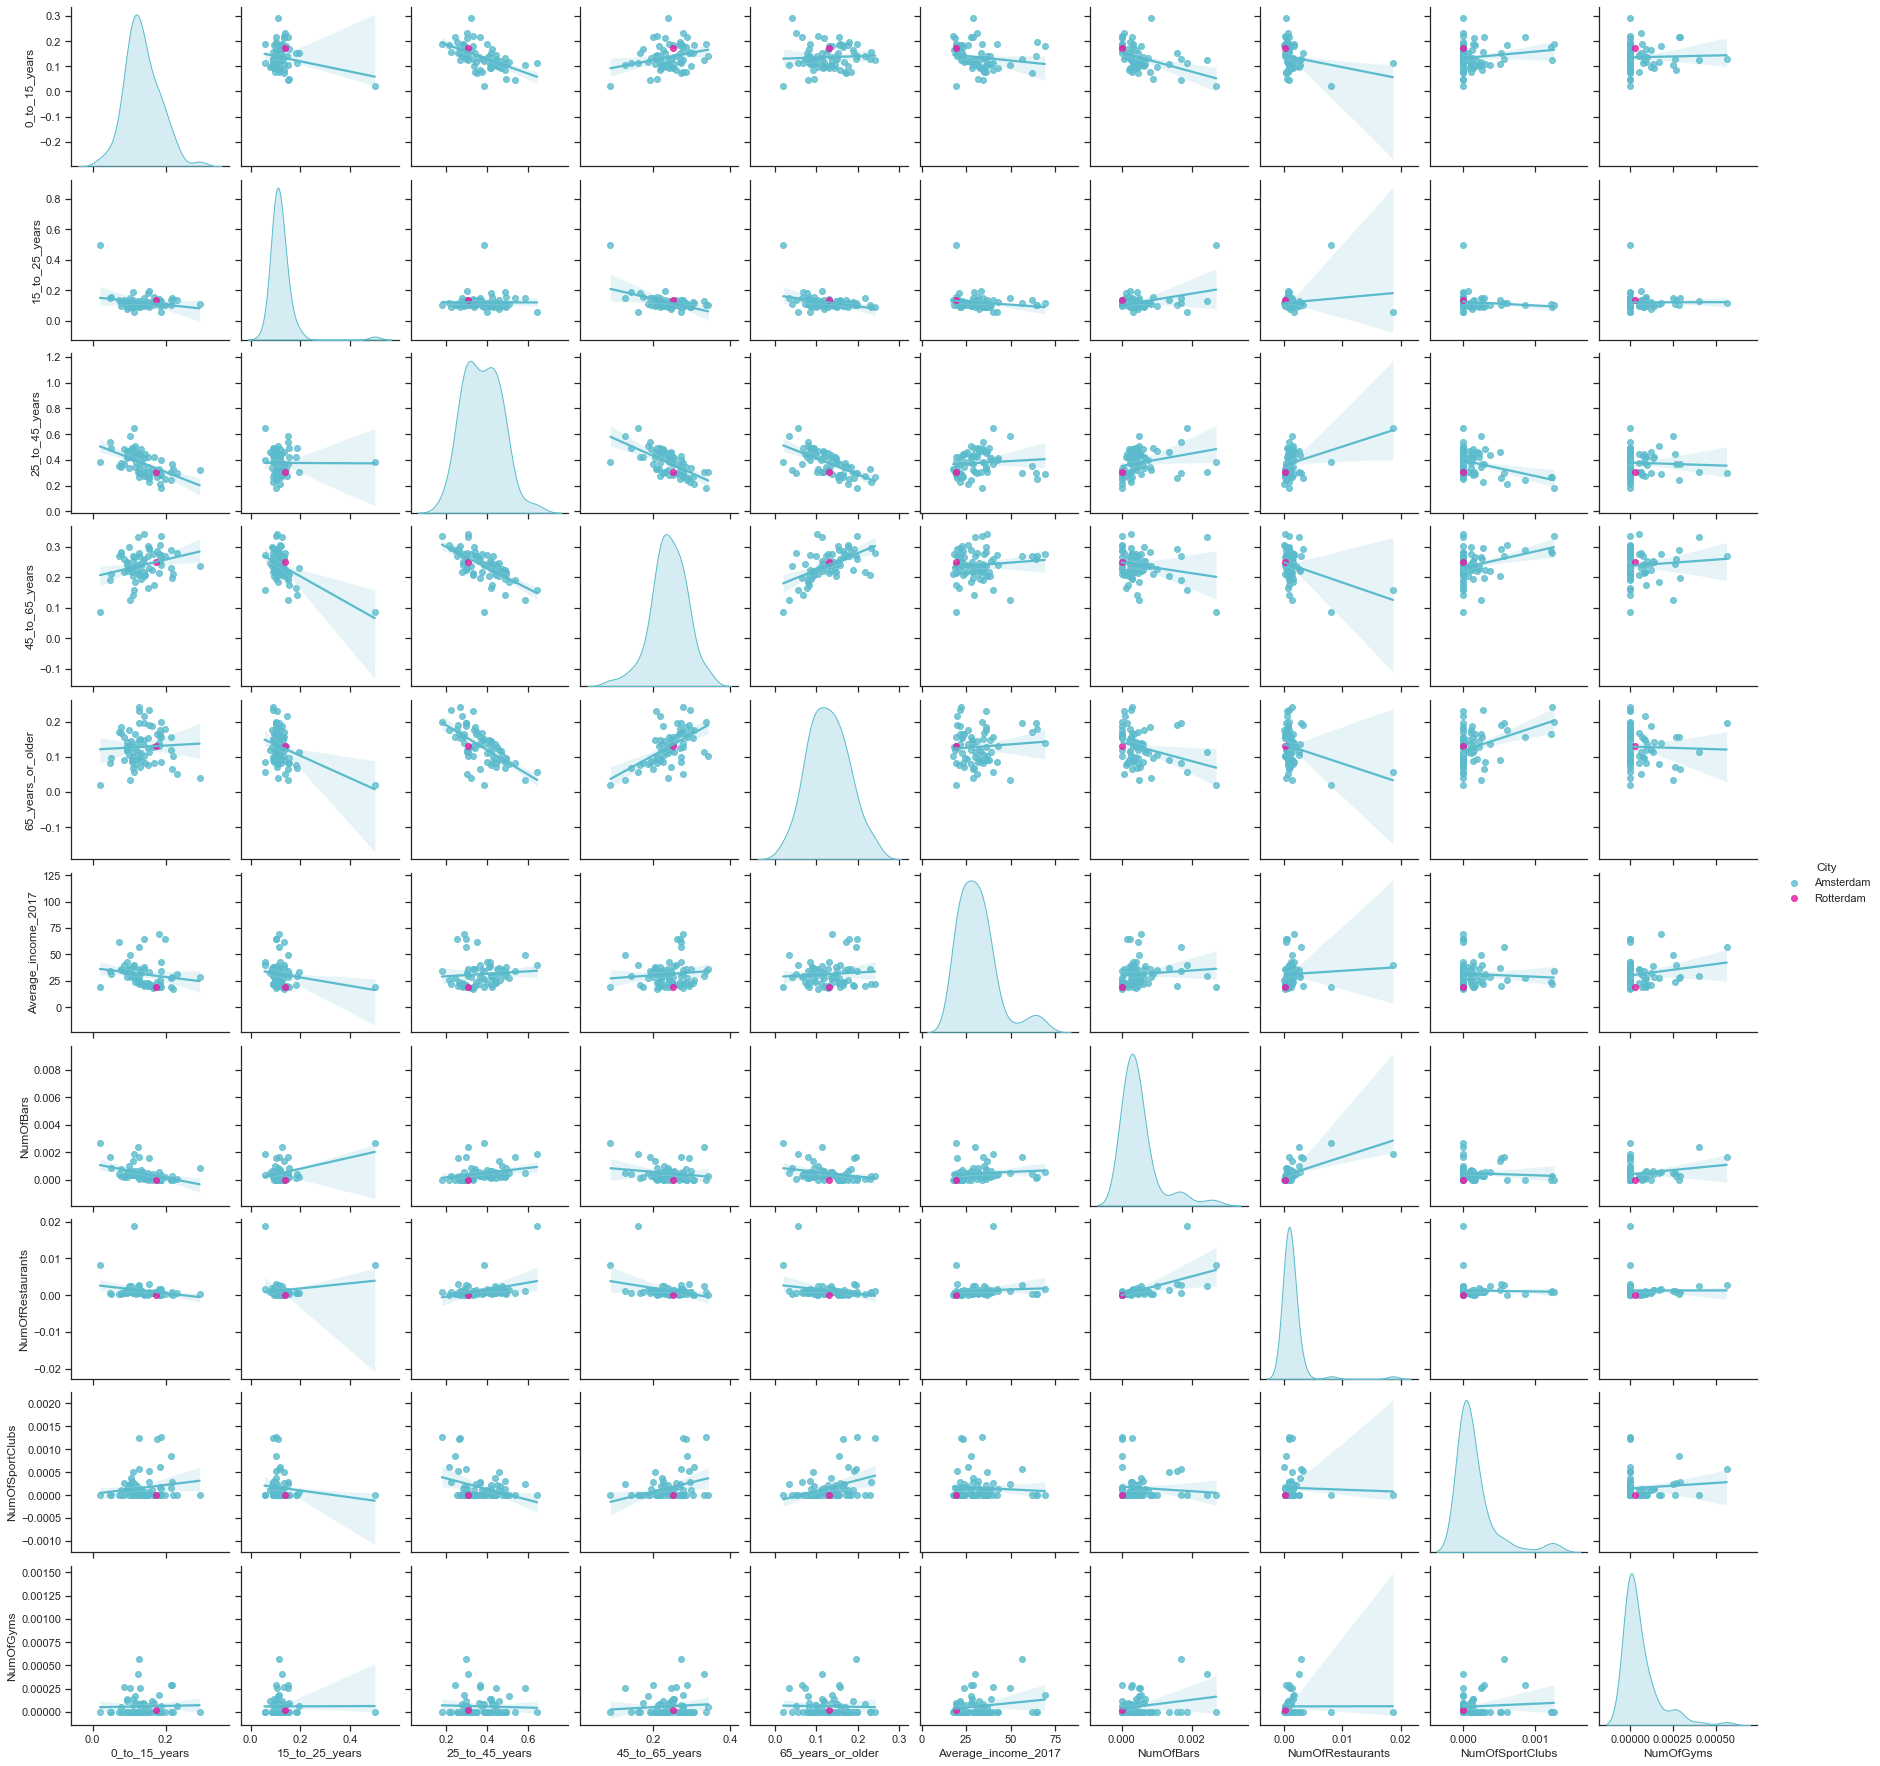

In [60]:
import seaborn as sns
sns.set_theme(style="ticks")

#Unnormalized data:
plotData = dataNormalized[["0_to_15_years",
                 "15_to_25_years",
                 "25_to_45_years",
                 "45_to_65_years",
                 "65_years_or_older", 
                 "Average_income_2017", 
                 "NumOfBars", 
                 "NumOfRestaurants", 
                 "NumOfSportClubs", 
                 "NumOfGyms", 
                 "City"]]
sns.pairplot(plotData, kind = "reg",diag_kind = "kde", hue = "City", palette = {'Amsterdam':'#5BBBCC', "Rotterdam": "#E31CA3"} )

## 3. Modelling

The data is unlabeled and the question is which boroughs (observations) are similar to Feijenoord Rotterdam. This means that the data has to be clustered. This can be done with the k-means algorithm. 

In [61]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [62]:
# Prepare dataset
modelColumns = dataNormalized[["0_to_15_years",
                               "15_to_25_years",
                               "25_to_45_years",
                               "45_to_65_years",
                               "65_years_or_older", 
                               "Average_income_2017", 
                               "NumOfBars", 
                               "NumOfRestaurants", 
                               "NumOfSportClubs"]]
cluster_dataset = StandardScaler().fit_transform(modelColumns)

First, the optimal number of clusters needs to be determined. Two methods have been compared to find the optimal number of clusters: the elbow method and the silhouette method. 
Using the elbow method the number of clusters is plotted against the sum of squared distances. The optimal number of clusters will be at the 'elbow' of the plot where the sum of squared distances does not descreases as rapidly with increasing clusters as before. 
When this method was applied to the data, no clear elbow point could be distinguished. The right figure below shows the elbow plot. The optimal number of clusters varies between the 6 and 8. 
Because the optimum was not clear using this method alone, the silhoutte method was also used. In this method the silhoutte score is plotted for the range of k's. This score measures how well a datapoint lies within a cluster, with one being perfect and 0 being close to the boundaries. A negative score means the point is outside the boundary. The left figure shows that the maximum silhouette score is at 6 clusters, matching the results of the elbow method. Therefore, 6 clusters was chosen as optimal.

Text(0.5, 1.0, 'Silhouette Method For Optimal k')

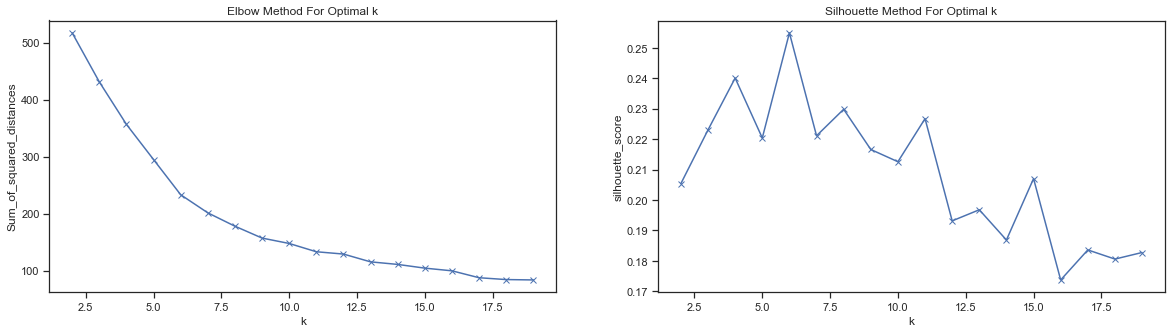

In [63]:
# Calculate the sum of squared distances for range of K's:
Sum_of_squared_distances = []
sil = []

K = range(2,20)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(cluster_dataset)
    labels_k = km.labels_
    Sum_of_squared_distances.append(km.inertia_)
    sil.append(silhouette_score(cluster_dataset, labels_k, metric = 'euclidean'))

# Plotting the ranges: 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(20,5))

ax1.plot(K, Sum_of_squared_distances, 'bx-')
ax1.set_xlabel('k')
ax1.set_ylabel('Sum_of_squared_distances')
ax1.set_title('Elbow Method For Optimal k')

ax2.plot(K,sil, 'bx-')
ax2.set_xlabel('k')
ax2.set_ylabel('silhouette_score')
ax2.set_title('Silhouette Method For Optimal k')


In [64]:
# Remodelling with k = 6 
num_clusters = 6

k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=12)
k_means.fit(cluster_dataset)
labels = k_means.labels_

print(labels)

[1 1 2 2 2 2 1 2 2 1 2 1 1 1 1 1 1 2 1 1 1 0 1 1 1 1 1 0 2 0 5 1 1 1 1 1 1
 1 2 2 1 2 0 1 1 1 0 0 3 0 0 3 3 0 3 0 0 0 3 0 0 3 0 0 0 1 1 0 4 0 3 0]


In [103]:
# Add labels to dataset: 
data["Labels"] = labels
data

,Key,City,Total Population,0_to_15_years,15_to_25_years,25_to_45_years,45_to_65_years,65_years_or_older,Average_income_2017,Name,Address,Latitude,Longitude,NumOfBars,NumOfGyms,NumOfRestaurants,NumOfSportClubs,NumOfGyms/100.000 persons,Labels
0,WK036300,Amsterdam,4465,0.049272,0.155655,0.491601,0.210526,0.095185,31.500000,Burgwallen-Oude Zijde,"Burgwallen-Oude Zijde, Amsterdam",52.371946,4.896103,4,0,2,0,0,1
1,WK036301,Amsterdam,4130,0.047215,0.148910,0.537530,0.190073,0.081114,34.500000,Burgwallen-Nieuwe Zijde,"Burgwallen-Nieuwe Zijde, Amsterdam",52.373706,4.889922,7,0,3,0,0,1
2,WK036302,Amsterdam,6435,0.073038,0.135198,0.351981,0.271173,0.170940,62.099998,Grachtengordel-West,"Grachtengordel-West, Amsterdam",52.370837,4.885478,3,0,2,0,0,2
3,WK036304,Amsterdam,9705,0.078310,0.113344,0.341577,0.284389,0.183926,36.200001,Nieuwmarkt/Lastage,"Nieuwmarkt/Lastage, Amsterdam",52.372177,4.906351,8,0,6,0,0,2
4,WK036305,Amsterdam,9275,0.100809,0.087871,0.337466,0.299730,0.175202,36.400002,Haarlemmerbuurt,"Haarlemmerbuurt, Amsterdam",52.382441,4.887193,6,0,7,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,WK036390,Amsterdam,13615,0.127433,0.104664,0.331987,0.206390,0.230261,36.000000,Buitenveldert-West,"Buitenveldert-West, Amsterdam",52.328647,4.873523,1,0,7,0,0,0
68,WK036392,Amsterdam,740,0.020270,0.500000,0.385135,0.087838,0.020270,19.500000,Amstel III/Bullewijk,"Amstel III/Bullewijk, Amsterdam",52.301099,4.951654,2,0,6,0,0,4
69,WK036397,Amsterdam,11325,0.152318,0.122737,0.269316,0.303753,0.152318,22.700001,Gein,"Gein, Amsterdam",52.297238,4.988091,0,0,2,0,0,0
70,WK036398,Amsterdam,1620,0.185185,0.117284,0.216049,0.305556,0.175926,26.200001,Driemond,"Driemond, Amsterdam",52.305405,5.016549,0,0,0,1,0,3


## 4. Results:
### 4.2  Visualizing the clusters on the map

In [66]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

In [93]:
# create map
latitude = 52.301099
longitude = 4.981825
map_clusters  = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(num_clusters)
ys = [i + x + (i*x)**2 for i in range(num_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
colors = ["#1556F0", "#A45CF5","#DA5CF5","#F55CA1","#5CF572", "F5A45C"]

# add markers to the map
markers_colors = []

for lat, lon, poi, cluster in zip(data['Latitude'], data['Longitude'], data['Name'], data['Labels']):
    if (cluster ==  0):
        label = folium.Popup(str(poi) + ' Cluster ' + str('Cluster of Feijenoord'), parse_html=True)
    else:
        label =  folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=colors[cluster],
        fill=True,
        fill_color=colors[cluster],
        fill_opacity=0.7).add_to(map_clusters)
map_clusters

The clustering of the buroughs can be used to identify the areas similar to that of Feijenoord, Rotterdam. Borougs that are close together geographically also tend to group together in one cluster. The coordinates of the buroughs has not been included for modelling the data. It can be expected that neighbouring buroughs are also similar in population distribution and venues. Although no conclusions can be drawn from these conclusion, it is indicative that the clustering of the data went as expected. 
Furthermore, it can be seen that the buroughs falling in the same cluster as Feijenoord are mostly in the suburbs, similar to Feijenoord. However, from this map no conclusion can be drawn about the basis upon which the clustered are created.

### 4.2 Zooming in on the clusters

In [68]:
import seaborn as sns
sns.set_theme(style="ticks")

In [102]:
# Rename cluster 5 to "Cluster of Feijenoord"
data.loc[(data["Labels"] == 0), "Labels"] = "Cluster of Feijenoord"

In [75]:
#Unnormalized data:
plotData = data[["0_to_15_years",
                 "15_to_25_years",
                 "25_to_45_years",
                 "45_to_65_years",
                 "65_years_or_older", 
                 "Average_income_2017", 
                 "NumOfBars", 
                 "NumOfRestaurants", 
                 "NumOfSportClubs", 
                 "Labels"]]

C:\Users\kooij\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\kooij\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\kooij\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\kooij\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\kooij\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\kooij\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

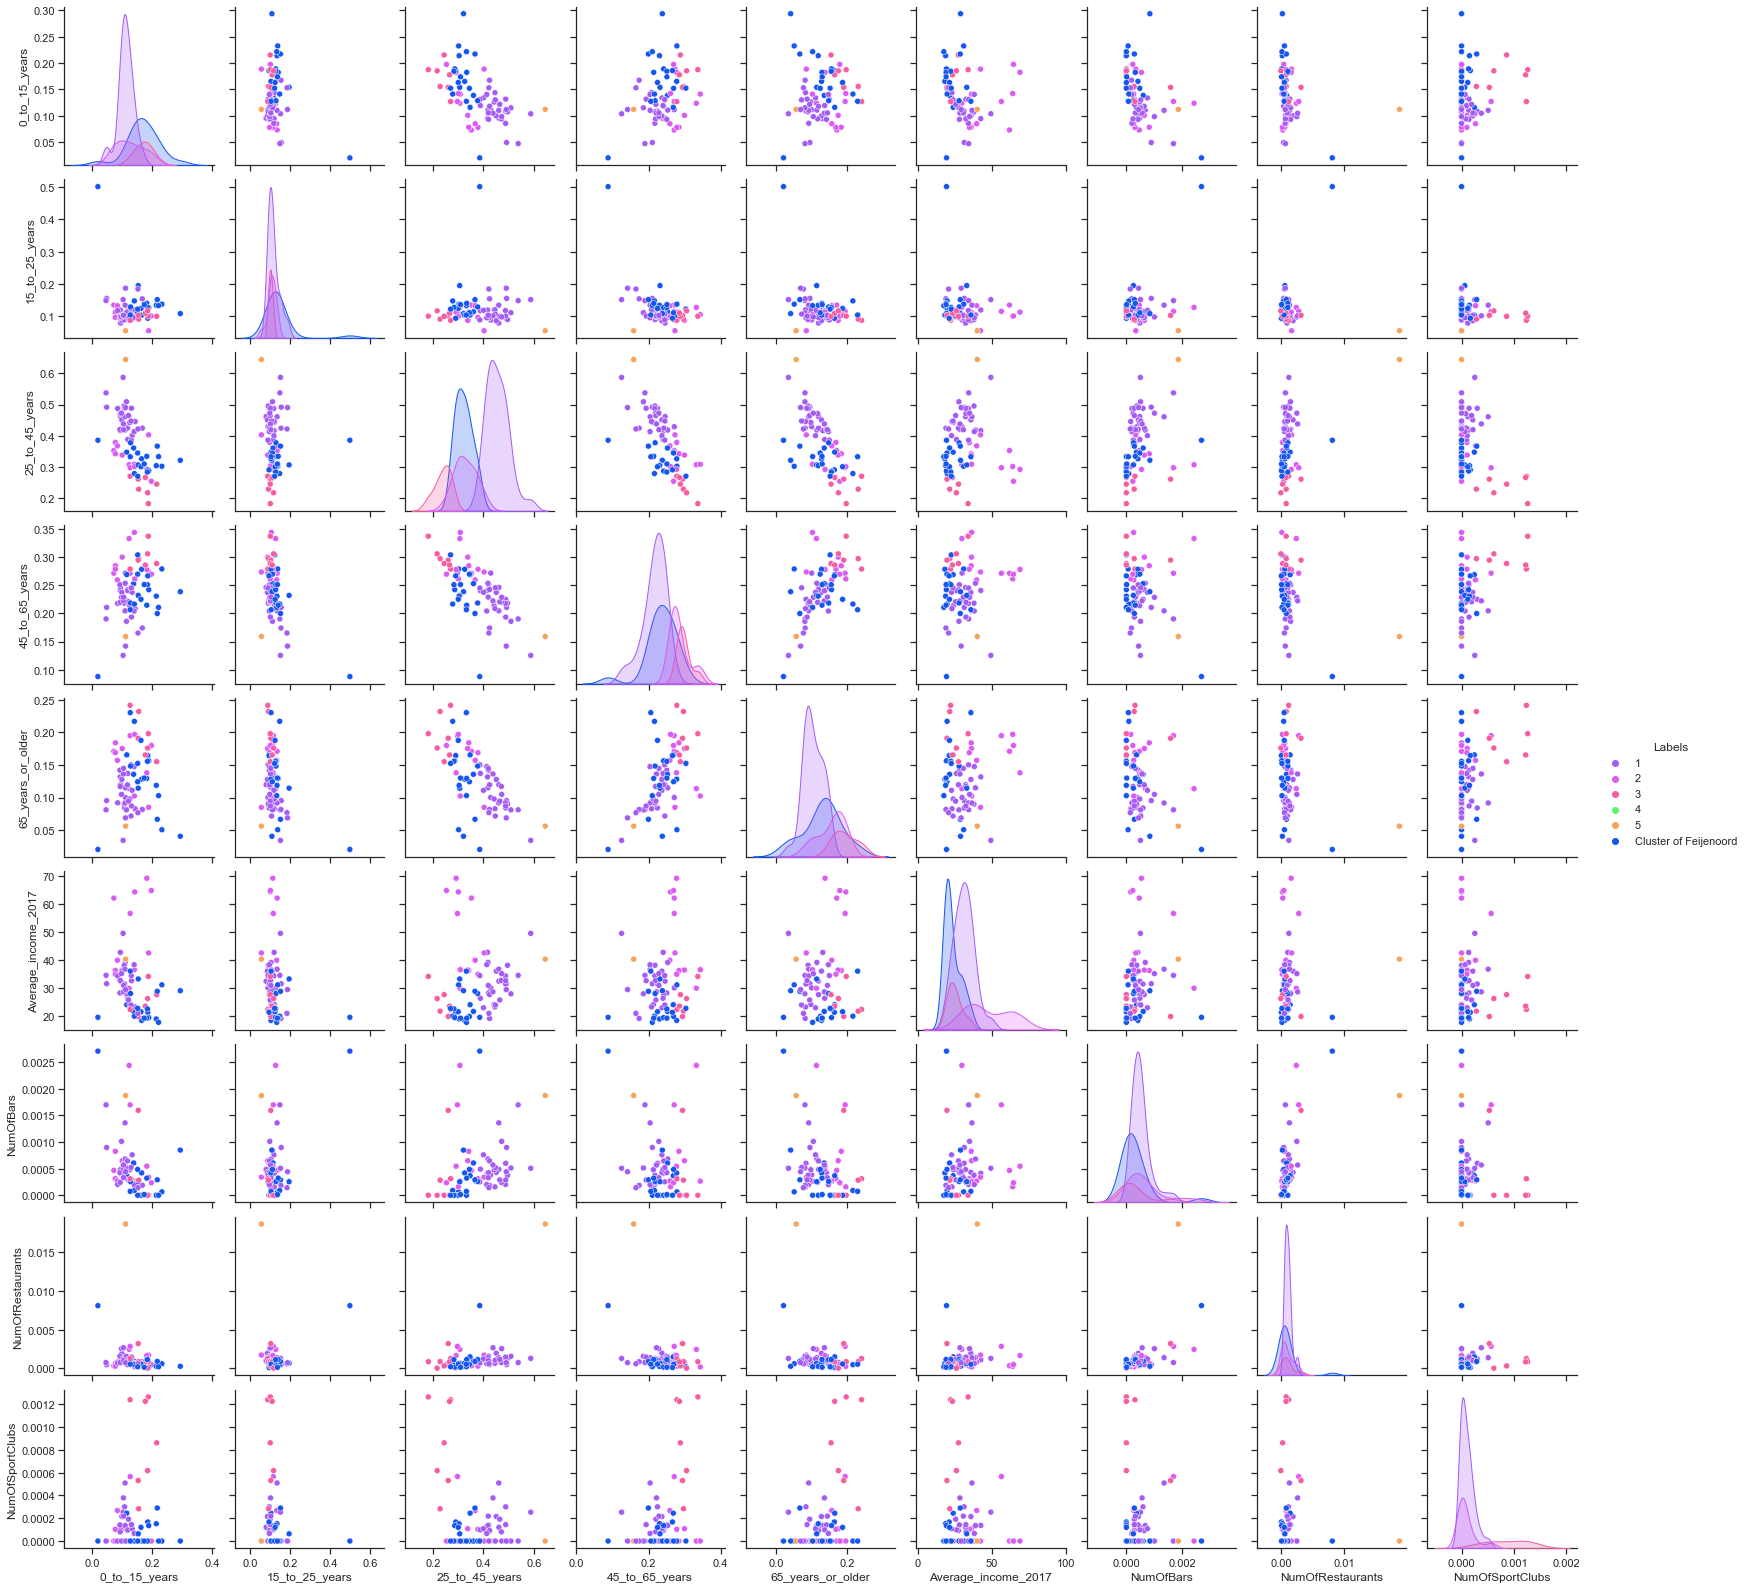

In [76]:
sns.pairplot(plotData, 
             hue="Labels", 
             hue_order = [1,2,3,4,5,"Cluster of Feijenoord"],
             palette = {4:"#5CF572", 1:"#A45CF5",2:"#DA5CF5",3:"#F55CA1", 5: "#F5A45C", "Cluster of Feijenoord": "#1556F0" })


C:\Users\kooij\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='Average_income_2017', ylabel='Density'>

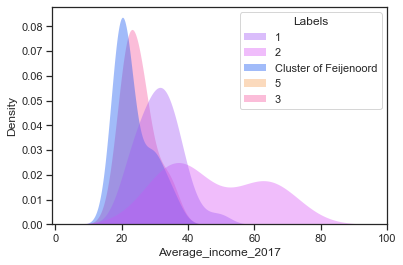

In [87]:
sns.kdeplot(
   data=plotData, x="Average_income_2017", hue="Labels",
   fill=True, common_norm=False, palette = {4:"#5CF572", 1:"#A45CF5",2:"#DA5CF5",3:"#F55CA1", 5: "#F5A45C", "Cluster of Feijenoord": "#1556F0" },
   alpha=.4, linewidth=0,
)

C:\Users\kooij\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='25_to_45_years', ylabel='Density'>

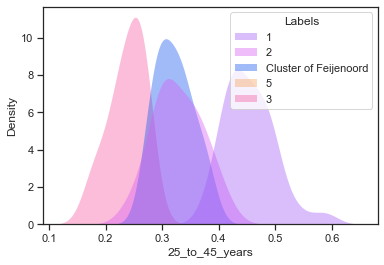

In [89]:
sns.kdeplot(
   data=plotData, x="25_to_45_years", hue="Labels",
   fill=True, common_norm=False, palette = {4:"#5CF572", 1:"#A45CF5",2:"#DA5CF5",3:"#F55CA1", 5: "#F5A45C", "Cluster of Feijenoord": "#1556F0" },
   alpha=.4, linewidth=0,
)

C:\Users\kooij\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='0_to_15_years', ylabel='Density'>

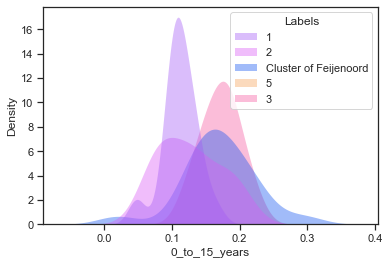

In [90]:
sns.kdeplot(
   data=plotData, x="0_to_15_years", hue="Labels",
   fill=True, common_norm=False, palette = {4:"#5CF572", 1:"#A45CF5",2:"#DA5CF5",3:"#F55CA1", 5: "#F5A45C", "Cluster of Feijenoord": "#1556F0" },
   alpha=.4, linewidth=0,
)

<AxesSubplot:xlabel='Labels', ylabel='25_to_45_years'>

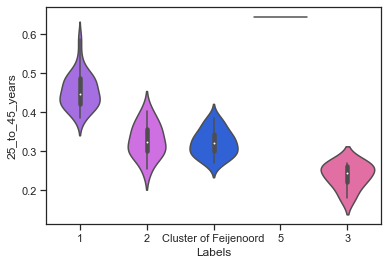

In [88]:
sns.violinplot(x="Labels", 
               y="25_to_45_years", 
               data=plotData, 
               palette = {4:"#5CF572", 1:"#A45CF5",2:"#DA5CF5",3:"#F55CA1", 5: "#F5A45C", "Cluster of Feijenoord": "#1556F0" },
               height=20)

The plot above shows the scatterplots of the different variables and the densities of the variable, all grouped per cluster indicated with the colors. Not one variable (combination) shows a true seperation between the different clusters. The most interesting distribution is that of the average income of the buroughs. For the cluster that contains Feijenoord the average income seems to be low compared to the other clusters. On average the number of venues seems to be lower for the cluster of Feijenoord, while the number of Sport Clubs seem to more average. This can also be expeceted as in the suburbs, in general more space is reserved for sport clubs. The age distribution for the Feijenoord cluster seems to be somewhat lower to average compared to the other buroughs. 

### 4.3 Competition!

Now that the similar buroughs to Feijenoord, Rotterdam are known for Amsterdam, a comparison on the compition for the gym in these areas. With the Foursquare data we also retrieved the number of gyms in a given area. This makes the comparision straightforward.
However, not all buroughs are similar in size or population. Therefore, the number of gyms has been normalized to the total population in the area, in the form of  the "number of gyms/ 100.000 persons": 

In [107]:
Compitition = data["NumOfGyms"]*100000
CompititionData = data 
CompititionData["NumOfGyms/100.000 persons"] = Compitition

#Filtering opn the label
CompititionData.loc[(CompititionData["Labels"] == 0), ].sort_values(["NumOfGyms/100.000 persons"])

,Key,City,Total Population,0_to_15_years,15_to_25_years,25_to_45_years,45_to_65_years,65_years_or_older,Average_income_2017,Name,Address,Latitude,Longitude,NumOfBars,NumOfGyms,NumOfRestaurants,NumOfSportClubs,NumOfGyms/100.000 persons,Labels
21,WK036326,Amsterdam,8190,0.115995,0.104396,0.346764,0.268620,0.165446,24.000000,Zuid Pijp,"Zuid Pijp, Amsterdam",52.353314,4.901963,0.000366,0.000000,0.001465,0.000244,0.000000,0
67,WK036390,Amsterdam,13615,0.127433,0.104664,0.331987,0.206390,0.230261,36.000000,Buitenveldert-West,"Buitenveldert-West, Amsterdam",52.328647,4.873523,0.000073,0.000000,0.000514,0.000000,0.000000,0
64,WK036385,Amsterdam,8135,0.184388,0.127843,0.282729,0.250768,0.155501,22.500000,Slotervaart Noord,"Slotervaart Noord, Amsterdam",52.361286,4.827466,0.000000,0.000000,0.001106,0.000000,0.000000,0
63,WK036383,Amsterdam,6225,0.182329,0.140562,0.333333,0.214458,0.129317,19.200001,De Punt,"De Punt, Amsterdam",52.355743,4.786042,0.000321,0.000000,0.001124,0.000000,0.000000,0
60,WK036378,Amsterdam,16530,0.221416,0.133394,0.332426,0.210526,0.102843,17.700001,Geuzenveld,"Geuzenveld, Amsterdam",52.378394,4.801628,0.000000,0.000000,0.000181,0.000000,0.000000,0
69,WK036397,Amsterdam,11325,0.152318,0.122737,0.269316,0.303753,0.152318,22.700001,Gein,"Gein, Amsterdam",52.297238,4.988091,0.000000,0.000000,0.000177,0.000000,0.000000,0
53,WK036365,Amsterdam,11955,0.185696,0.094521,0.289837,0.266416,0.164366,21.299999,Tuindorp Oostzaan,"Tuindorp Oostzaan, Amsterdam",52.412796,4.888052,0.000000,0.000000,0.000084,0.000167,0.000000,0
55,WK036368,Amsterdam,13190,0.213798,0.134572,0.303260,0.230478,0.118650,18.900000,Waterlandpleinbuurt,"Waterlandpleinbuurt, Amsterdam",52.394294,4.953580,0.000000,0.000000,0.000227,0.000152,0.000000,0
49,WK036360,Amsterdam,9560,0.165272,0.104079,0.325314,0.278243,0.128138,18.400000,Volewijck,"Volewijck, Amsterdam",52.389362,4.911523,0.000418,0.000000,0.000628,0.000000,0.000000,0
42,WK036351,Amsterdam,8265,0.293406,0.108893,0.320629,0.238355,0.040532,29.000000,IJburg Zuid,"IJburg Zuid, Amsterdam",52.373145,4.891336,0.000847,0.000000,0.000242,0.000000,0.000000,0


In [121]:
# Visualize on map: 
latitude = 52.301099
longitude = 4.981825
map_clusters  = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(num_clusters)
ys = [i + x + (i*x)**2 for i in range(num_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
colors = ["#2bff00","#f08500","#ff001a"]

# add markers to the map
markers_colors = []

plotdata2 =CompititionData.loc[(CompititionData["Labels"] == 0), ] 
plotdata2["NumOfGyms/100.000 persons"] = pd.cut(plotdata2["NumOfGyms/100.000 persons"], bins=3, 
                              labels=[0, 1, 2])

for lat, lon, poi, cluster in zip(plotdata2['Latitude'], plotdata2['Longitude'], plotdata2['Name'], plotdata2['NumOfGyms/100.000 persons']):
    if (cluster ==  0):
        label = folium.Popup(str(poi) + ' Competition: ' + str('Low'), parse_html=True)
    
    elif (cluster ==  1):
        label = folium.Popup(str(poi) + ' Competition: ' + str('Medium'), parse_html=True)
    
    elif (cluster ==  2):
        label = folium.Popup(str(poi) + ' Competition: ' + str('High'), parse_html=True)
    
    folium.CircleMarker(
        [lat, lon],
        radius=15,
        popup=label,
        color= colors[cluster],
        fill=True,
        fill_color=colors[cluster],
        fill_opacity=0.75).add_to(map_clusters)
map_clusters

<ipython-input-121-e6bb201dac99>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plotdata2["NumOfGyms/100.000 persons"] = pd.cut(plotdata2["NumOfGyms/100.000 persons"], bins=3,
